In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import math

In [2]:
data_path = r"D:\dataset\data_residuos"
classes = os.listdir(data_path)
num_classes = len(classes)
print(num_classes)
print(classes)

5
['borrador', 'citrico', 'salsa', 'tableta', 'tajador']


In [3]:
# transformaciones
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
class ResiduosDataset(Dataset):
    def __init__(self, data_path, classes, transform=None, patch_size=(8, 8), max_samples=2000):
        self.data_path = data_path
        self.classes = classes
        self.transform = transform
        self.patch_size = patch_size
        self.image_paths = []
        self.labels = []
        
        for class_idx, class_name in enumerate(classes):
            class_path = os.path.join(data_path, class_name)
            all_images = os.listdir(class_path)
            selected_images = all_images[:max_samples]
            
            for img_name in selected_images:
                img_path = os.path.join(class_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        c, h, w = image.shape
        patch_h, patch_w = self.patch_size
        
        num_patches_h = h // patch_h
        num_patches_w = w // patch_w
        num_patches = num_patches_h * num_patches_w
        
        patches = image.unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
        patches = patches.contiguous().view(c, num_patches, patch_h * patch_w)
        patches = patches.permute(1, 0, 2)
        patches = patches.contiguous().view(num_patches, -1)
        
        return patches, label

In [5]:
class ResiduosData(pl.LightningDataModule):
    def __init__(self, data_path, classes, batch_size=32, patch_size=(8, 8)):
        super().__init__()
        self.data_path = data_path
        self.classes = classes
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.transform = transform

    def setup(self, stage=None):
        full_dataset = ResiduosDataset(self.data_path, self.classes, self.transform, self.patch_size, max_samples=2000)

        train_size = int(0.9 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        self.train_ds, self.val_ds = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [6]:
class ScaledDotSelfAttention(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.n_embd = n_embd
        self.key = nn.Linear(n_embd, n_embd // 2)
        self.query = nn.Linear(n_embd, n_embd // 2)
        self.value = nn.Linear(n_embd, n_embd // 2)
        self.output = nn.Linear(n_embd // 2, n_embd)

    def forward(self, x):
        B, L, C = x.size()
        
        k = self.key(x)  
        q = self.query(x)  
        v = self.value(x)  

        d_k = k.size(-1)  
        scale_factor = 1.0 / torch.sqrt(torch.tensor(d_k, dtype=torch.float32, device=x.device))
        
        att = (q @ k.transpose(1, 2)) * scale_factor  
        att = F.softmax(att, dim=-1)
        y = att @ v 
        y = self.output(y)  
        
        return y

In [7]:
# Modelo con Attention
class ResiduosAttention(pl.LightningModule):
    def __init__(self, n_embd=192, seq_len=196, num_classes=5):
        super().__init__()
        
        self.attn = ScaledDotSelfAttention(n_embd)
        self.pool = nn.AdaptiveAvgPool1d(64)  
        self.classifier = nn.Linear(192, num_classes)

    def forward(self, x):
        x = self.attn(x)
        
        x = x.transpose(1, 2)  
        x = self.pool(x)      
        x = x.mean(dim=2)     
        
        x = self.classifier(x)
        return x
    
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
    
    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc
    
    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)  
        return optimizer

In [8]:
# configuracion 
patch_size = (8, 8)
img_size = 112
n_embd = 3 * 8 * 8
seq_len = (img_size // patch_size[0]) * (img_size // patch_size[1])

# datamodule
dm = ResiduosData(data_path, classes, batch_size=32, patch_size=(8, 8))
dm.setup()

# verificar un batch
imgs, labels = next(iter(dm.train_dataloader()))
print(f"batch shape: {imgs.shape}")

model = ResiduosAttention(n_embd=192, seq_len=196, num_classes=num_classes)

batch shape: torch.Size([32, 196, 192])


In [9]:
# train
trainer = pl.Trainer(max_epochs=11, accelerator='gpu', devices=1 if torch.cuda.is_available() else None, enable_progress_bar=True, logger=None, enable_checkpointing=False,)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
d:\IA2025\inteligencia_artificial\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params | Mode 
--------------------------------------------------------------
0 | attn       | ScaledDotSelfAttention | 74.2 K | train
1 | pool       | AdaptiveAvgPool1d      | 0      | train
2 | classifier | Linear                 | 965    | train
---------------------------------------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\IA2025\inteligencia_artificial\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


d:\IA2025\inteligencia_artificial\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 10: 100%|██████████| 282/282 [00:39<00:00,  7.16it/s, v_num=11, train_loss=1.120, train_acc=0.625, val_loss=1.160, val_acc=0.563]

`Trainer.fit` stopped: `max_epochs=11` reached.


Epoch 10: 100%|██████████| 282/282 [00:39<00:00,  7.16it/s, v_num=11, train_loss=1.120, train_acc=0.625, val_loss=1.160, val_acc=0.563]


Acc batch de validación: 75.00%


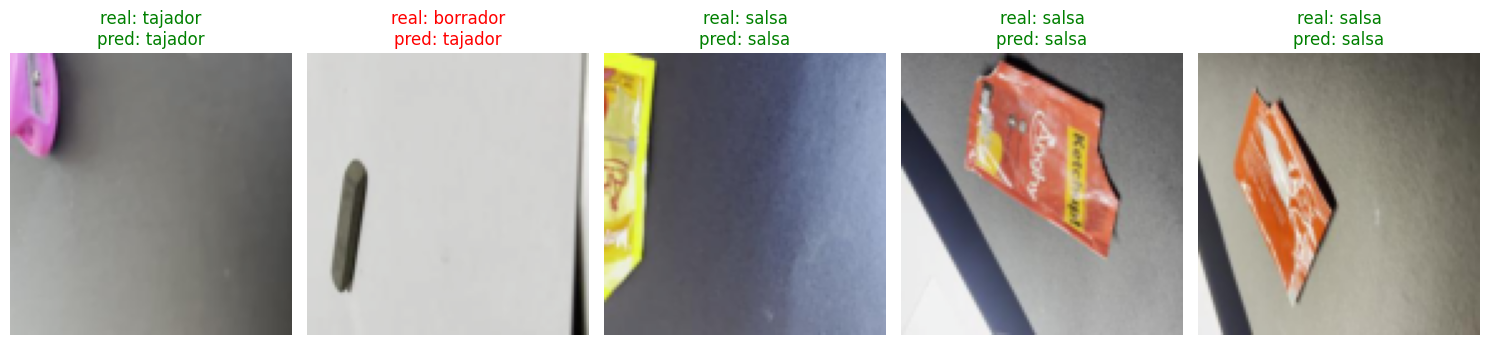

In [15]:
# evaluacion 
model.eval()
val_imgs, val_labels = next(iter(dm.val_dataloader()))
preds = model.predict(val_imgs)

accuracy = (val_labels == preds.cpu()).float().mean()
print(f"Acc batch de validación: {accuracy.item()*100:.2f}%")

# resultados
def visualize(imgs, labels, preds, classes, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    
    for i in range(min(num_samples, len(imgs))):
        patch_seq = imgs[i]
        c, h, w = 3, 8, 8
        patches_per_side = int(math.sqrt(patch_seq.shape[0]))
        
        reconstructed = patch_seq.view(patches_per_side, patches_per_side, c, h, w)
        reconstructed = reconstructed.permute(2, 0, 3, 1, 4).contiguous()
        reconstructed = reconstructed.view(c, patches_per_side * h, patches_per_side * w)
        reconstructed = reconstructed.permute(1, 2, 0).cpu().numpy()
        
        reconstructed = (reconstructed * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        reconstructed = np.clip(reconstructed, 0, 1)
        
        axes[i].imshow(reconstructed)
        axes[i].set_title(f'real: {classes[labels[i]]}\npred: {classes[preds[i]]}', 
                         color='green' if labels[i] == preds[i] else 'red')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize(val_imgs, val_labels, preds, classes)